In [9]:
import torch
import math
import matplotlib.pyplot as plt
from matplotlib.cm import Set2 as NodeColors
from time import time
from interpol.energies import flowreg, make_evalkernels1d, flow_upsample2, spline_from_coeff_nd
from interpol import resize, spline_coeff_nd, grid_grad, grid_hess, identity_grid, grid_pull

In [130]:
BOUND = 'circulant'
ANCHOR = 'edge'
NDIM = 2
ORDER = 3
NORM = False
SHAPE = 10
MAXSHAPE = 64

MAXFAC = int(round(math.log2(MAXSHAPE/SHAPE)))

torch.set_default_dtype(torch.float64)

In [131]:
# sample spline coefficients on a coarse grid
fullshape = [SHAPE] * NDIM + [NDIM]
coeff = torch.randn(*fullshape) * SHAPE / 4
# coeff, VX = torch.load('/tmp/coeff.dat')

# coarse to fine pyramid of grids
shapes = torch.arange(SHAPE, MAXSHAPE+1).tolist()

# I make it so the voxel size is 1 when the grid is finest, because of
# instabilities observed when working with tiny voxel sizes
# (I think when taking 1/vx**2 during scaling of the derivatives)
vxs = [shapes[-1] / shape for shape in shapes]
VX = vxs[0]

energy = {
    (e, m, u): []
    for e in ('abs', 'mem', 'ben', 'div')
    for m in ('ana', 'eva', 'dif')
    for u in ('samp', 'coef', 'mse')
}
timing = {
    (e, m, u): []
    for e in ('abs', 'mem', 'ben', 'div')
    for m in ('ana', 'eva', 'dif')
    for u in ('samp', 'coef', 'mse')
}
timing['resz'] = []
timing['coef'] = []
timing['grad'] = []
timing['hess'] = []
timing['grid'] = []

for shape, vx in zip(shapes, vxs):
    # Upsample flow
    tic = time()
    grid = identity_grid([shape]*NDIM)
    grid *= SHAPE/shape
    grid += 0.5 * (SHAPE/shape - 1)
    timing['grid'] += [time() - tic]
    tic = time()
    flow = grid_pull(coeff.movedim(-1, 0), grid, ORDER, BOUND, True, False).movedim(0, -1)
    timing['resz'] += [time() - tic]
    tic = time()
    grad = grid_grad(coeff.movedim(-1, 0), grid, ORDER, BOUND, True, False).movedim(0, -2)
    timing['grad'] += [time() - tic]
    tic = time()
    hess = grid_hess(coeff.movedim(-1, 0), grid, ORDER, BOUND, True, False).movedim(0, -3)
    timing['hess'] += [time() - tic]
    tic = time()
    coeff1 = spline_coeff_nd(
        flow.movedim(-1, 0), interpolation=ORDER, bound=BOUND, dim=NDIM
    ).movedim(0, -1)
    toc = time()
    timing['coef'] += [toc - tic]
    flow *= shape/SHAPE
    coeff1 *= shape/SHAPE
    evalabs = flow.square().sum()
    evalmem = grad.square().sum()
    evalben = hess.square().sum()
    evaldiv = grad.diagonal(0, -1, -2).sum(-1).square().sum()
    if NORM:
        evalabs *= (vx*vx) / (2*shape**NDIM)
        evalmem /= (2*shape**NDIM)
        evalben /= (2*VX*VX*shape**NDIM)
        evaldiv /= (2*shape**NDIM)
    else:
        evalabs *= 0.5 * vx**(NDIM+2)
        evalmem *= 0.5 * vx**(NDIM)
        evalben *= 0.5 * vx**(NDIM) / (VX*VX)
        evaldiv *= 0.5 * vx**(NDIM)
    # ------------------------------------------------------------------
    # Exact energy (analytical gradients, analytical integration)
    # ------------------------------------------------------------------
    OPT = dict(order=ORDER, bound=BOUND, norm=NORM, voxel_size=vx)
    tic = time()
    energy[('abs', 'ana', 'coef')] += [flowreg(coeff1, absolute=1, **OPT)]
    timing[('abs', 'ana', 'coef')] += [time() - tic]
    tic = time()
    energy[('mem', 'ana', 'coef')] += [flowreg(coeff1, membrane=1, **OPT)]
    timing[('mem', 'ana', 'coef')] += [time() - tic]
    tic = time()
    energy[('ben', 'ana', 'coef')] += [flowreg(coeff1, bending=1, **OPT)]
    timing[('ben', 'ana', 'coef')] += [time() - tic]
    tic = time()
    energy[('div', 'ana', 'coef')] += [flowreg(coeff1, div=1, **OPT)]
    timing[('div', 'ana', 'coef')] += [time() - tic]
    # ------------------------------------------------------------------
    # Approximate energy (analytical gradients, discrete integration)
    # ------------------------------------------------------------------
    #       Variant 1: upsample flow -> coeff -> kernel
    # ------------------------------------------------------------------
    OPT = dict(order=ORDER, bound=BOUND, norm=NORM, voxel_size=vx,
               kernels1d=make_evalkernels1d(ORDER))
    tic = time()
    energy[('abs', 'eva', 'coef')] += [flowreg(coeff1, absolute=1, **OPT)]
    timing[('abs', 'eva', 'coef')] += [time() - tic]
    tic = time()
    energy[('mem', 'eva', 'coef')] += [flowreg(coeff1, membrane=1, **OPT)]
    timing[('mem', 'eva', 'coef')] += [time() - tic]
    tic = time()
    energy[('ben', 'eva', 'coef')] += [flowreg(coeff1, bending=1, **OPT)]
    timing[('ben', 'eva', 'coef')] += [time() - tic]
    tic = time()
    energy[('div', 'eva', 'coef')] += [flowreg(coeff1, div=1, **OPT)]
    timing[('div', 'eva', 'coef')] += [time() - tic]
    # ------------------------------------------------------------------
    #       Variant 2: Evaluate energy at upsampled coordinates
    # ------------------------------------------------------------------
    energy[('abs', 'eva', 'samp')] += [evalabs]
    timing[('abs', 'eva', 'samp')] += [timing['resz'][-1]]
    energy[('mem', 'eva', 'samp')] += [evalmem]
    timing[('mem', 'eva', 'samp')] += [timing['grid'][-1] + timing['grad'][-1]]
    energy[('ben', 'eva', 'samp')] += [evalben]
    timing[('ben', 'eva', 'samp')] += [timing['grid'][-1] + timing['hess'][-1]]
    energy[('div', 'eva', 'samp')] += [evaldiv]
    timing[('div', 'eva', 'samp')] += [timing['grid'][-1] + timing['grad'][-1]]
    # ------------------------------------------------------------------
    # Finite-difference energy (discrete gradients, discrete integration)
    # ------------------------------------------------------------------
    #       Variant 1: evaluate flow, then convolve with FD kernel
    # ------------------------------------------------------------------
    OPT = dict(fd=True, order=1, bound=BOUND, norm=NORM, voxel_size=vx)
    tic = time()
    energy[('abs', 'dif', 'samp')] += [flowreg(flow, absolute=1, **OPT)]
    timing[('abs', 'dif', 'samp')] += [time() - tic]
    tic = time()
    energy[('mem', 'dif', 'samp')] += [flowreg(flow, membrane=1, **OPT)]
    timing[('mem', 'dif', 'samp')] += [time() - tic]
    tic = time()
    energy[('ben', 'dif', 'samp')] += [flowreg(flow, bending=1, **OPT)]
    timing[('ben', 'dif', 'samp')] += [time() - tic]
    tic = time()
    energy[('div', 'dif', 'samp')] += [flowreg(flow, div=1, **OPT)]
    timing[('div', 'dif', 'samp')] += [time() - tic]
    # ------------------------------------------------------------------
    #       Variant 2: convolve with joint "eval + FD" kernel
    # ------------------------------------------------------------------
    OPT = dict(fd=True, order=ORDER, bound=BOUND, norm=NORM, voxel_size=vx)
    tic = time()
    energy[('abs', 'dif', 'coef')] += [flowreg(coeff1, absolute=1, **OPT)]
    timing[('abs', 'dif', 'coef')] += [time() - tic]
    tic = time()
    energy[('mem', 'dif', 'coef')] += [flowreg(coeff1, membrane=1, **OPT)]
    timing[('mem', 'dif', 'coef')] += [time() - tic]
    tic = time()
    energy[('ben', 'dif', 'coef')] += [flowreg(coeff1, bending=1, **OPT)]
    timing[('ben', 'dif', 'coef')] += [time() - tic]
    tic = time()
    energy[('div', 'dif', 'coef')] += [flowreg(coeff1, div=1, **OPT)]
    timing[('div', 'dif', 'coef')] += [time() - tic]

In [132]:
intfactors = list(range(MAXFAC+1))
intshapes = [SHAPE * 2**f for f in intfactors]
intvxs = [shapes[-1] / shape for shape in intshapes]

for shape, vx in zip(intshapes, intvxs):
    coeff1 = coeff
    logfactor = int(math.log2(shape//SHAPE))
    for _ in range(logfactor):
        coeff1 = flow_upsample2(coeff1, order=ORDER, bound=BOUND)

    OPT = dict(order=ORDER, bound=BOUND, norm=NORM, voxel_size=vx)
    energy[('abs', 'ana', 'mse')] += [flowreg(coeff1, absolute=1, **OPT)]
    energy[('mem', 'ana', 'mse')] += [flowreg(coeff1, membrane=1, **OPT)]
    energy[('ben', 'ana', 'mse')] += [flowreg(coeff1, bending=1, **OPT)]
    energy[('div', 'ana', 'mse')] += [flowreg(coeff1, div=1, **OPT)]

    OPT = dict(order=ORDER, bound=BOUND, norm=NORM, voxel_size=vx,
               kernels1d=make_evalkernels1d(ORDER))
    energy[('abs', 'eva', 'mse')] += [flowreg(coeff1, absolute=1, **OPT)]
    energy[('mem', 'eva', 'mse')] += [flowreg(coeff1, membrane=1, **OPT)]
    energy[('ben', 'eva', 'mse')] += [flowreg(coeff1, bending=1, **OPT)]
    energy[('div', 'eva', 'mse')] += [flowreg(coeff1, div=1, **OPT)]

    OPT = dict(fd=True, order=ORDER, bound=BOUND, norm=NORM, voxel_size=vx)
    energy[('abs', 'dif', 'mse')] += [flowreg(coeff1, absolute=1, **OPT)]
    energy[('mem', 'dif', 'mse')] += [flowreg(coeff1, membrane=1, **OPT)]
    energy[('ben', 'dif', 'mse')] += [flowreg(coeff1, bending=1, **OPT)]
    energy[('div', 'dif', 'mse')] += [flowreg(coeff1, div=1, **OPT)]

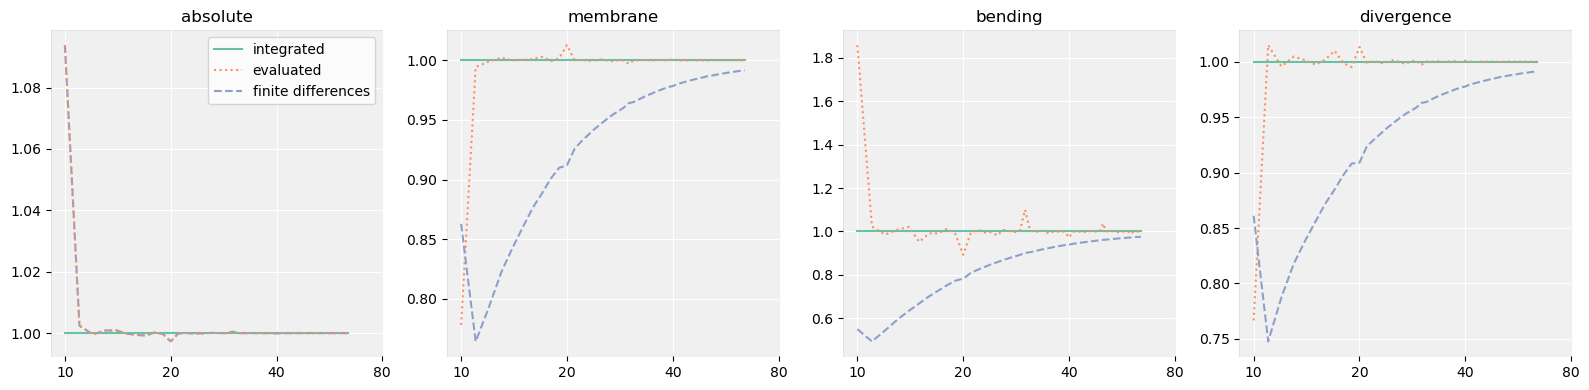

In [133]:
plt.figure(figsize=(16, 4))
colors = NodeColors(range(4))

gridshape = (1, 4)


# plt.set_cmap()
plt.subplot(*gridshape, 1)
true_energy = energy[('abs', 'ana', 'coef')][0]
plt.grid(color='white')
plt.plot([shapes[0], shapes[-1]], [1, 1], color=colors[0], zorder=1000)
plt.plot(shapes, list(map(lambda x: x / true_energy, energy[('abs', 'eva', 'samp')])), ':', color=colors[1], zorder=3000)
plt.plot(shapes, list(map(lambda x: x / true_energy, energy[('abs', 'dif', 'samp')])), '--', color=colors[2], zorder=2000)
plt.gca().set_xscale('log')
plt.gca().set_facecolor('#0F0F0F0F')
plt.gca().spines['top'].set_color('#0F0F0F0F')
plt.gca().spines['bottom'].set_color('#0F0F0F0F')
plt.gca().spines['left'].set_color('#0F0F0F0F')
plt.gca().spines['right'].set_color('#0F0F0F0F')
# plt.gca().set_yscale('log')
# plt.xticks([SHAPE * 2**f for f in range(MAXFAC+1)], [''] * (MAXFAC+1))
plt.xticks([SHAPE * 2**f for f in range(MAXFAC+1)],
           map(str, [SHAPE * 2**f for f in range(MAXFAC+1)]))
# plt.gca().tick_params(axis='x', color='w')
plt.minorticks_off()
plt.legend(['integrated', 'evaluated', 'finite differences'])
plt.title('absolute')

plt.subplot(*gridshape, 2)
true_energy = energy[('mem', 'ana', 'coef')][0]
plt.grid(color='white')
plt.plot([shapes[0], shapes[-1]], [1, 1], color=colors[0])
plt.plot(shapes, list(map(lambda x: x / true_energy, energy[('mem', 'eva', 'samp')])), ':', color=colors[1])
plt.plot(shapes, list(map(lambda x: x / true_energy, energy[('mem', 'dif', 'samp')])), '--', color=colors[2])
plt.gca().set_xscale('log')
plt.gca().set_facecolor('#0F0F0F0F')
plt.gca().spines['top'].set_color('#0F0F0F0F')
plt.gca().spines['bottom'].set_color('#0F0F0F0F')
plt.gca().spines['left'].set_color('#0F0F0F0F')
plt.gca().spines['right'].set_color('#0F0F0F0F')
# plt.gca().tick_params(axis='x', color='w')
# plt.gca().set_yscale('log')
# plt.xticks([SHAPE * 2**f for f in range(MAXFAC+1)], [''] * (MAXFAC+1))
plt.xticks([SHAPE * 2**f for f in range(MAXFAC+1)],
           map(str, [SHAPE * 2**f for f in range(MAXFAC+1)]))
plt.minorticks_off()
plt.title('membrane')

plt.subplot(*gridshape, 3)
true_energy = energy[('ben', 'ana', 'coef')][0]
plt.grid(color='white')
plt.plot([shapes[0], shapes[-1]], [1, 1], color=colors[0])
plt.plot(shapes, list(map(lambda x: x / true_energy, energy[('ben', 'eva', 'samp')])), ':', color=colors[1])
plt.plot(shapes, list(map(lambda x: x / true_energy, energy[('ben', 'dif', 'samp')])), '--', color=colors[2])
plt.gca().set_xscale('log')
plt.gca().set_facecolor('#0F0F0F0F')
plt.gca().spines['top'].set_color('#0F0F0F0F')
plt.gca().spines['bottom'].set_color('#0F0F0F0F')
plt.gca().spines['left'].set_color('#0F0F0F0F')
plt.gca().spines['right'].set_color('#0F0F0F0F')
# plt.gca().set_yscale('log')
plt.xticks([SHAPE * 2**f for f in range(MAXFAC+1)],
           map(str, [SHAPE * 2**f for f in range(MAXFAC+1)]))
plt.minorticks_off()
plt.title('bending')

plt.subplot(*gridshape, 4)
true_energy = energy[('div', 'ana', 'coef')][0]
plt.grid(color='white')
plt.plot([shapes[0], shapes[-1]], [1, 1], color=colors[0])
plt.plot(shapes, list(map(lambda x: x / true_energy, energy[('div', 'eva', 'samp')])), ':', color=colors[1])
plt.plot(shapes, list(map(lambda x: x / true_energy, energy[('div', 'dif', 'samp')])), '--', color=colors[2])
plt.gca().set_xscale('log')
plt.gca().set_facecolor('#0F0F0F0F')
plt.gca().spines['top'].set_color('#0F0F0F0F')
plt.gca().spines['bottom'].set_color('#0F0F0F0F')
plt.gca().spines['left'].set_color('#0F0F0F0F')
plt.gca().spines['right'].set_color('#0F0F0F0F')
plt.xticks([SHAPE * 2**f for f in range(MAXFAC+1)],
           map(str, [SHAPE * 2**f for f in range(MAXFAC+1)]))
plt.minorticks_off()
plt.title('divergence')


plt.tight_layout()
# plt.savefig('/Users/yb947/Dropbox/papers/YB24_splinereg/errors.pdf')
plt.show()

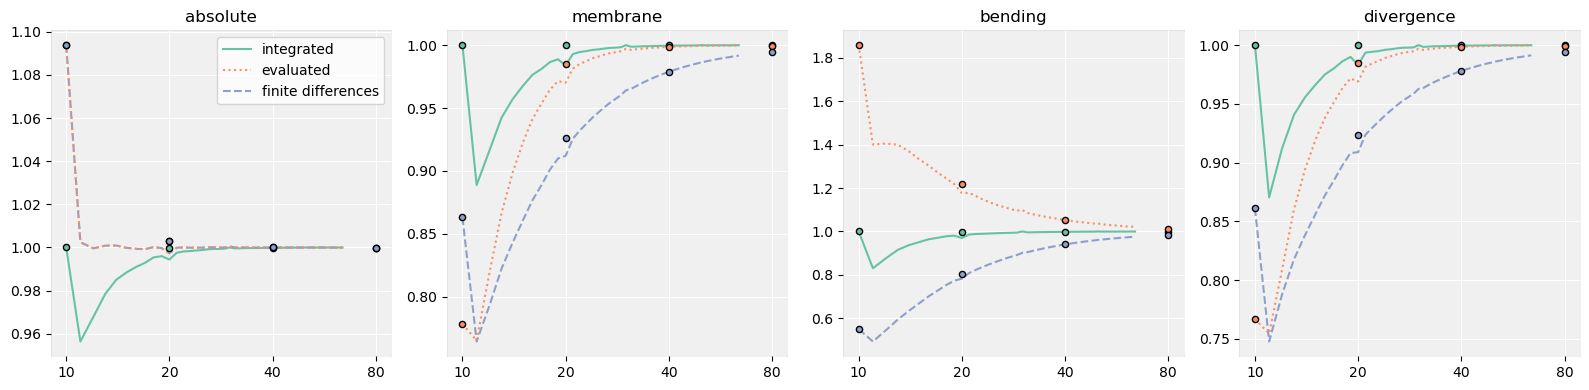

In [134]:
plt.figure(figsize=(16, 4))
colors = NodeColors(range(4))

gridshape = (1, 4)

# plt.set_cmap()
plt.subplot(*gridshape, 1)
true_energy = energy[('abs', 'ana', 'coef')][0]
plt.grid(color='white')
plt.plot(shapes, list(map(lambda x: x / true_energy, energy[('abs', 'ana', 'coef')])), '-', color=colors[0])
plt.plot(shapes, list(map(lambda x: x / true_energy, energy[('abs', 'eva', 'coef')])), ':', color=colors[1], zorder=100)
plt.plot(shapes, list(map(lambda x: x / true_energy, energy[('abs', 'dif', 'coef')])), '--', color=colors[2])
plt.scatter(intshapes, list(map(lambda x: x / true_energy, energy[('abs', 'ana', 'mse')])), 20, color=colors[0], zorder=1000, edgecolors='k', linewidths=1)
plt.scatter(intshapes, list(map(lambda x: x / true_energy, energy[('abs', 'eva', 'mse')])), 20, color=colors[1], zorder=2000, edgecolors='k', linewidths=1)
plt.scatter(intshapes, list(map(lambda x: x / true_energy, energy[('abs', 'dif', 'mse')])), 20, color=colors[2], zorder=3000, edgecolors='k', linewidths=1)
plt.gca().set_xscale('log')
plt.gca().set_facecolor('#0F0F0F0F')
plt.gca().spines['top'].set_color('#0F0F0F0F')
plt.gca().spines['bottom'].set_color('#0F0F0F0F')
plt.gca().spines['left'].set_color('#0F0F0F0F')
plt.gca().spines['right'].set_color('#0F0F0F0F')
# plt.gca().set_yscale('log')
# plt.xticks([SHAPE * 2**f for f in range(MAXFAC+1)], [''] * (MAXFAC+1))
plt.xticks([SHAPE * 2**f for f in range(MAXFAC+1)],
           map(str, [SHAPE * 2**f for f in range(MAXFAC+1)]))
# plt.gca().tick_params(axis='x', color='w')
plt.minorticks_off()
plt.legend(['integrated', 'evaluated', 'finite differences'])
plt.title('absolute')

plt.subplot(*gridshape, 2)
true_energy = energy[('mem', 'ana', 'coef')][0]
plt.grid(color='white')
plt.plot(shapes, list(map(lambda x: x / true_energy, energy[('mem', 'ana', 'coef')])), '-', color=colors[0])
plt.plot(shapes, list(map(lambda x: x / true_energy, energy[('mem', 'eva', 'coef')])), ':', color=colors[1], zorder=100)
plt.plot(shapes, list(map(lambda x: x / true_energy, energy[('mem', 'dif', 'coef')])), '--', color=colors[2])
plt.scatter(intshapes, list(map(lambda x: x / true_energy, energy[('mem', 'ana', 'mse')])), 20, color=colors[0], zorder=1000, edgecolors='k', linewidths=1)
plt.scatter(intshapes, list(map(lambda x: x / true_energy, energy[('mem', 'eva', 'mse')])), 20, color=colors[1], zorder=2000, edgecolors='k', linewidths=1)
plt.scatter(intshapes, list(map(lambda x: x / true_energy, energy[('mem', 'dif', 'mse')])), 20, color=colors[2], zorder=3000, edgecolors='k', linewidths=1)
plt.gca().set_xscale('log')
plt.gca().set_facecolor('#0F0F0F0F')
plt.gca().spines['top'].set_color('#0F0F0F0F')
plt.gca().spines['bottom'].set_color('#0F0F0F0F')
plt.gca().spines['left'].set_color('#0F0F0F0F')
plt.gca().spines['right'].set_color('#0F0F0F0F')
# plt.gca().tick_params(axis='x', color='w')
# plt.gca().set_yscale('log')
# plt.xticks([SHAPE * 2**f for f in range(MAXFAC+1)], [''] * (MAXFAC+1))
plt.xticks([SHAPE * 2**f for f in range(MAXFAC+1)],
           map(str, [SHAPE * 2**f for f in range(MAXFAC+1)]))
plt.minorticks_off()
plt.title('membrane')

plt.subplot(*gridshape, 3)
true_energy = energy[('ben', 'ana', 'coef')][0]
plt.grid(color='white')
plt.plot(shapes, list(map(lambda x: x / true_energy, energy[('ben', 'ana', 'coef')])), '-', color=colors[0])
plt.plot(shapes, list(map(lambda x: x / true_energy, energy[('ben', 'eva', 'coef')])), ':', color=colors[1], zorder=100)
plt.plot(shapes, list(map(lambda x: x / true_energy, energy[('ben', 'dif', 'coef')])), '--', color=colors[2])
plt.scatter(intshapes, list(map(lambda x: x / true_energy, energy[('ben', 'ana', 'mse')])), 20, color=colors[0], zorder=1000, edgecolors='k', linewidths=1)
plt.scatter(intshapes, list(map(lambda x: x / true_energy, energy[('ben', 'eva', 'mse')])), 20, color=colors[1], zorder=2000, edgecolors='k', linewidths=1)
plt.scatter(intshapes, list(map(lambda x: x / true_energy, energy[('ben', 'dif', 'mse')])), 20, color=colors[2], zorder=3000, edgecolors='k', linewidths=1)
plt.gca().set_xscale('log')
plt.gca().set_facecolor('#0F0F0F0F')
plt.gca().spines['top'].set_color('#0F0F0F0F')
plt.gca().spines['bottom'].set_color('#0F0F0F0F')
plt.gca().spines['left'].set_color('#0F0F0F0F')
plt.gca().spines['right'].set_color('#0F0F0F0F')
# plt.gca().set_yscale('log')
plt.xticks([SHAPE * 2**f for f in range(MAXFAC+1)],
           map(str, [SHAPE * 2**f for f in range(MAXFAC+1)]))
plt.minorticks_off()
plt.title('bending')

plt.subplot(*gridshape, 4)
true_energy = energy[('div', 'ana', 'coef')][0]
plt.grid(color='white')
plt.plot(shapes, list(map(lambda x: x / true_energy, energy[('div', 'ana', 'coef')])), '-', color=colors[0])
plt.plot(shapes, list(map(lambda x: x / true_energy, energy[('div', 'eva', 'coef')])), ':', color=colors[1], zorder=100)
plt.plot(shapes, list(map(lambda x: x / true_energy, energy[('div', 'dif', 'coef')])), '--', color=colors[2])
plt.scatter(intshapes, list(map(lambda x: x / true_energy, energy[('div', 'ana', 'mse')])), 20, color=colors[0], zorder=1000, edgecolors='k', linewidths=1)
plt.scatter(intshapes, list(map(lambda x: x / true_energy, energy[('div', 'eva', 'mse')])), 20, color=colors[1], zorder=2000, edgecolors='k', linewidths=1)
plt.scatter(intshapes, list(map(lambda x: x / true_energy, energy[('div', 'dif', 'mse')])), 20, color=colors[2], zorder=3000, edgecolors='k', linewidths=1)
plt.gca().set_xscale('log')
plt.gca().set_facecolor('#0F0F0F0F')
plt.gca().spines['top'].set_color('#0F0F0F0F')
plt.gca().spines['bottom'].set_color('#0F0F0F0F')
plt.gca().spines['left'].set_color('#0F0F0F0F')
plt.gca().spines['right'].set_color('#0F0F0F0F')
plt.xticks([SHAPE * 2**f for f in range(MAXFAC+1)],
           map(str, [SHAPE * 2**f for f in range(MAXFAC+1)]))
plt.minorticks_off()
plt.title('divergence')


plt.tight_layout()
# plt.savefig('/Users/yb947/Dropbox/papers/YB24_splinereg/errors.pdf')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/yb947/Dropbox/papers/YB24_splinereg/speed.pdf'

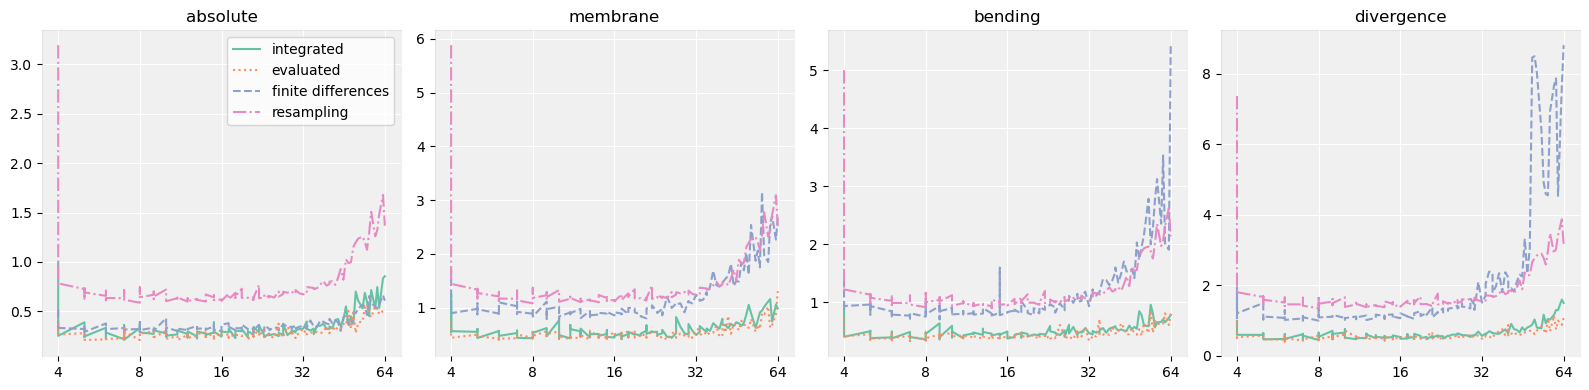

In [13]:

plt.figure(figsize=(16, 4))
colors = NodeColors(range(5))

gridshape = (1, 4)

# plt.set_cmap()
plt.subplot(*gridshape, 1)
plt.grid(color='white')
plt.plot(shapes, list(map(lambda x: x / time_abs_anly[0], time_abs_anly)), color=colors[0])
plt.plot(shapes, list(map(lambda x: x / time_abs_anly[0], time_abs_eval)), ':', color=colors[1], zorder=100)
plt.plot(shapes, list(map(lambda x: x / time_abs_anly[0], time_abs_diff)), '--', color=colors[2])
plt.plot(shapes, list(map(lambda x: x / time_abs_anly[0], time_resize)), '-.', color=colors[3])
plt.gca().set_xscale('log')
plt.gca().set_facecolor('#0F0F0F0F')
plt.gca().spines['top'].set_color('#0F0F0F0F')
plt.gca().spines['bottom'].set_color('#0F0F0F0F')
plt.gca().spines['left'].set_color('#0F0F0F0F')
plt.gca().spines['right'].set_color('#0F0F0F0F')
# plt.gca().set_yscale('log')
# plt.xticks([SHAPE * 2**f for f in range(MAXFAC+1)], [''] * (MAXFAC+1))
plt.xticks([SHAPE * 2**f for f in range(MAXFAC+1)],
           map(str, [SHAPE * 2**f for f in range(MAXFAC+1)]))
# plt.gca().tick_params(axis='x', color='w')
plt.minorticks_off()
plt.legend(['integrated', 'evaluated', 'finite differences', 'resampling'])
plt.title('absolute')

plt.subplot(*gridshape, 2)
plt.grid(color='white')
plt.plot(shapes, list(map(lambda x: x / time_mem_anly[0], time_mem_anly)), color=colors[0])
plt.plot(shapes, list(map(lambda x: x / time_mem_anly[0], time_mem_eval)), ':', color=colors[1])
plt.plot(shapes, list(map(lambda x: x / time_mem_anly[0], time_mem_diff)), '--', color=colors[2])
plt.plot(shapes, list(map(lambda x: x / time_mem_anly[0], time_resize)), '-.', color=colors[3])
plt.gca().set_xscale('log')
plt.gca().set_facecolor('#0F0F0F0F')
plt.gca().spines['top'].set_color('#0F0F0F0F')
plt.gca().spines['bottom'].set_color('#0F0F0F0F')
plt.gca().spines['left'].set_color('#0F0F0F0F')
plt.gca().spines['right'].set_color('#0F0F0F0F')
# plt.gca().tick_params(axis='x', color='w')
# plt.gca().set_yscale('log')
# plt.xticks([SHAPE * 2**f for f in range(MAXFAC+1)], [''] * (MAXFAC+1))
plt.xticks([SHAPE * 2**f for f in range(MAXFAC+1)],
           map(str, [SHAPE * 2**f for f in range(MAXFAC+1)]))
plt.minorticks_off()
plt.title('membrane')

plt.subplot(*gridshape, 3)
plt.grid(color='white')
plt.plot(shapes, list(map(lambda x: x / time_ben_anly[0], time_ben_anly)), color=colors[0])
plt.plot(shapes, list(map(lambda x: x / time_ben_anly[0], time_ben_eval)), ':', color=colors[1])
plt.plot(shapes, list(map(lambda x: x / time_ben_anly[0], time_ben_diff)), '--', color=colors[2])
plt.plot(shapes, list(map(lambda x: x / time_ben_anly[0], time_resize)), '-.', color=colors[3])
plt.gca().set_xscale('log')
plt.gca().set_facecolor('#0F0F0F0F')
plt.gca().spines['top'].set_color('#0F0F0F0F')
plt.gca().spines['bottom'].set_color('#0F0F0F0F')
plt.gca().spines['left'].set_color('#0F0F0F0F')
plt.gca().spines['right'].set_color('#0F0F0F0F')
# plt.gca().set_yscale('log')
plt.xticks([SHAPE * 2**f for f in range(MAXFAC+1)],
           map(str, [SHAPE * 2**f for f in range(MAXFAC+1)]))
plt.minorticks_off()
plt.title('bending')

plt.subplot(*gridshape, 4)
plt.grid(color='white')
plt.plot(shapes, list(map(lambda x: x / time_div_anly[0], time_div_anly)), color=colors[0])
plt.plot(shapes, list(map(lambda x: x / time_div_anly[0], time_div_eval)), ':', color=colors[1])
plt.plot(shapes, list(map(lambda x: x / time_div_anly[0], time_div_diff)), '--', color=colors[2])
plt.plot(shapes, list(map(lambda x: x / time_div_anly[0], time_resize)), '-.', color=colors[3])
plt.gca().set_xscale('log')
plt.gca().set_facecolor('#0F0F0F0F')
plt.gca().spines['top'].set_color('#0F0F0F0F')
plt.gca().spines['bottom'].set_color('#0F0F0F0F')
plt.gca().spines['left'].set_color('#0F0F0F0F')
plt.gca().spines['right'].set_color('#0F0F0F0F')
plt.xticks([SHAPE * 2**f for f in range(MAXFAC+1)],
           map(str, [SHAPE * 2**f for f in range(MAXFAC+1)]))
plt.minorticks_off()
plt.title('divergence')


plt.tight_layout()
plt.savefig('/Users/yb947/Dropbox/papers/YB24_splinereg/speed.pdf')
plt.show()